<div align="right">(29-Mar-2022)</div>
<h1>Prepare Dataset and Calculate Similarities</h1>
     
* Join structures for ChEMBL Ids
* Add compound in question

* Calculate Tanimoto Similarities for 2 fingerprints
  * full structures
  * Murcko scaffolds

The ChEMBL database in v30 was downloaded as g'zipped SD file from [ChEMBL](https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_30.sdf.gz) and standardized and stereochemistry removed, but not deduplicated, with the `stand_struct.py` script:

```
$ stand_struct chembl_30.sdf.gz fullrac -d --nocanon
```

The full ChEMBL data set was NOT included in this repository, only the identified Smoothened antagonists.

In [1]:
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to silence scikit-learn warnings

import warnings
warnings.filterwarnings('ignore')
warnings.warn = warn

# Type hints
from typing import Iterable, List, Set, Dict, Union, Optional

import os, gc
import functools

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem, QED
from rdkit.Chem import Descriptors as Desc
from rdkit.Chem import rdMolDescriptors as rdMolDesc
from rdkit.Chem import Fragments
from rdkit.Chem.Scaffolds import MurckoScaffold
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import IPythonConsole
from Contrib.NP_Score import npscorer

from rdkit.Chem.MolStandardize.tautomer import TautomerCanonicalizer
molvs_t = TautomerCanonicalizer(max_tautomers=100)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Project-local Imports
from jupy_tools import plt_style
from jupy_tools import utils as u, mol_view as mv, pca
from jupy_tools.utils import info

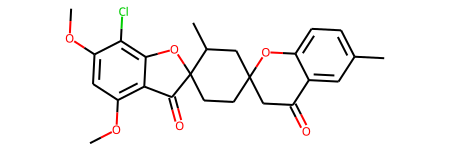

In [2]:
# Grismonone, stereochemistry removed:
pnp_id = 413261  # Internal Compound_Id
pnp_smiles = "COc1cc(OC)c2c(c1Cl)OC1(CCC3(CC(=O)c4cc(C)ccc4O3)CC1C)C2=O"
activity = "SmoAnta"
u.smiles_to_mol(pnp_smiles)

## Functions

In [3]:
@functools.lru_cache
def fp_from_smiles(smi, fp_type="ecfc4"):
    mol = Chem.MolFromSmiles(smi)
    assert mol is not None, f"Could not parse smiles: {smi}"
    if fp_type == "ecfc4":
        fp = Chem.GetMorganFingerprint(mol, 2)
    elif fp_type == "ecfp6":
        fp = Chem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    else:
        raise ValueError(f"Unknown fp_type: {fp_type}")
    return fp

def tani_sim(smiles1, smiles2, fp_type):
    fp1 = fp_from_smiles(smiles1, fp_type)
    fp2 = fp_from_smiles(smiles2, fp_type)
    return round(DataStructs.TanimotoSimilarity(fp1, fp2), 3)

def class_sim(list1, list2=None, fp_type="ecfc4"):
    result = []
    if list2 is None: # comparison within one class
        last_index = len(list1) - 1
    else:
        last_index = len(list1)
    for idx1, smi1 in tqdm(enumerate(list1[:last_index]), total=last_index):
        if list2 is None:
            for smi2 in list1[idx1+1:]:
                result.append(tani_sim(smi1, smi2, fp_type=fp_type))
        else:
            for smi2 in list2:
                result.append(tani_sim(smi1, smi2, fp_type=fp_type))
    return result

## Prepare Dataset

### Join ChEMBL structures to ChEMBL Ids

In [4]:
tmp = u.read_tsv("input/smo_chembl_ids.tsv")
df_act = tmp.copy()
# The following file is not included in the repository
df_chembl = u.read_tsv("/home/pahl/comas/notebooks/sdf/chembl30/chembl_30_fullrac_nocanon_dupl.tsv.gz")
df_act = pd.merge(df_act, df_chembl, on="chembl_id", how="inner")
print("Not found:")
set(tmp["chembl_id"].values) - set(df_act["chembl_id"].values)
df_act = df_act.rename(columns={"chembl_id": "Cpd_Id"})
df_act["DataSet"] =  activity
df_act["CpdClass"] =  activity
info(df_act, f"ChEMBL {activity}")

read_tsv                           : [     615 /   1 ] ( chembl_id )
read_tsv                           : [ 2136075 /   4 ] ( Name, chembl_id, InChIKey, Smiles )
Not found:


set()

ChEMBL SmoAnta                     : [     615 /   6 ] ( Cpd_Id, Name, InChIKey, Smiles, DataSet, CpdClass )


Add PNP

In [5]:
df_int = pd.DataFrame({"Cpd_Id": [str(pnp_id)], "DataSet": ["PNP"], "CpdClass": ["PNP"], "Smiles": [pnp_smiles]})
df_all = pd.concat([df_act, df_int])
info(df_all, "All")

All                                : [     616 /   6 ] ( Cpd_Id, Name, InChIKey, Smiles, DataSet, CpdClass )


In [6]:
u.write_tsv(df_all, "input/smiles_all.tsv")

## Full Structures


### Chemical Similarities

of `pnp_id` to the published ChEMBL compounds.


In [7]:
def fp_from_smiles(smi, fp_type="ecfc4"):
    mol = Chem.MolFromSmiles(smi)
    assert mol is not None, f"Could not parse smiles: {smi}"
    if fp_type == "ecfc4":
        fp = Chem.GetMorganFingerprint(mol, 2)
    elif fp_type == "ecfp6":
        fp = Chem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    else:
        raise ValueError(f"Unknown fp_type: {fp_type}")
    return fp

def TaniSim(ref_fp, smiles, fp_type):
    fp = fp_from_smiles(smiles, fp_type)
    return round(DataStructs.TanimotoSimilarity(ref_fp, fp), 3)

In [8]:
df_all = u.read_tsv("input/smiles_all.tsv")
df_tani = df_all.query(f'DataSet == "{activity}"').copy()
for fp_type in ["ecfc4", "ecfp6"]:
    fp_pnp = fp_from_smiles(pnp_smiles, fp_type)
    df_tani[fp_type.upper()] = df_tani.Smiles.progress_apply(lambda x: TaniSim(fp_pnp, x, fp_type))
u.write_tsv(df_tani, "output/ecdf_tani_sim_full.tsv")
print("Median ECFC4 similarity:", df_tani["ECFC4"].median())
print("Median ECFP6 similarity:", df_tani["ECFP6"].median())
info(df_tani, "TaniSim")

read_tsv                           : [     616 /   6 ] ( Cpd_Id, Name, InChIKey, Smiles, DataSet, CpdClass )


  0%|          | 0/615 [00:00<?, ?it/s]

  0%|          | 0/615 [00:00<?, ?it/s]

Median ECFC4 similarity: 0.142
Median ECFP6 similarity: 0.097
TaniSim                            : [     615 /   8 ] ( Cpd_Id, Name, InChIKey, Smiles, DataSet, CpdClass, ECFC4, ECFP6 )


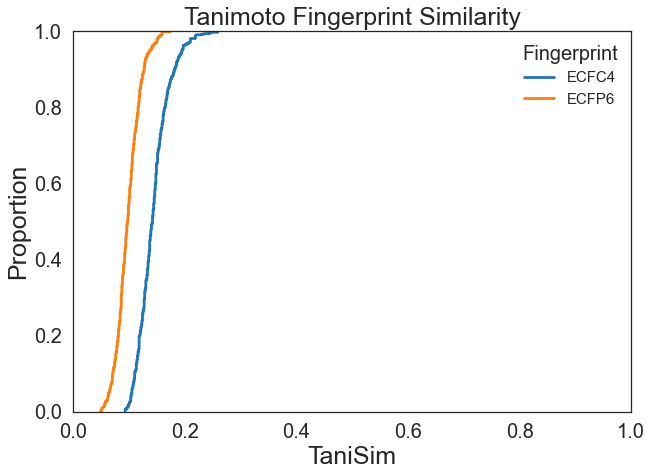

In [9]:
tmp = pd.melt(df_tani, id_vars=['Cpd_Id'], value_vars=["ECFC4", "ECFP6"],
              var_name="Fingerprint", value_name="TaniSim")
plt.figure(figsize=(10, 7))
sns.ecdfplot(data=tmp, x="TaniSim", stat="proportion", hue="Fingerprint")
plt.xlim((0, 1));
# plt.legend();
plt.title(f"Tanimoto Fingerprint Similarity")
plt.savefig("output/ecdf_tani_sim_full.png");
plt.savefig("output/ecdf_tani_sim_full.svg");

### Murcko Scaffolds

In [10]:
df_all = u.read_tsv("input/smiles_all.tsv")
df_murcko = df_all.query(f'DataSet == "{activity}"').copy()

# Canonicalize Tautomer
df_murcko = u.calc_from_smiles(df_murcko, "Stand_Smiles", lambda x: u.standardize_mol(x, canonicalize_tautomer=True))
df_murcko = u.drop_cols(df_murcko, ["InChIKey", "Smiles"])
df_murcko = df_murcko.rename(columns={'Stand_Smiles': 'Smiles'})
df_murcko = u.remove_nans(df_murcko, "Smiles")

# Murcko Scaffold
df_murcko = u.murcko_from_smiles(df_murcko)
df_murcko = u.drop_cols(df_murcko, ["Murcko_InChIKey", "Smiles"])
df_murcko = df_murcko.rename(columns={'Murcko_Smiles': 'Smiles'})

# Canonicalize again
df_murcko = u.calc_from_smiles(df_murcko, "Stand_Smiles", lambda x: u.standardize_mol(x, canonicalize_tautomer=True))
df_murcko = u.drop_cols(df_murcko, "Smiles")
df_murcko = df_murcko.rename(columns={'Stand_Smiles': 'Smiles'})
df_murcko = u.remove_nans(df_murcko, "Smiles")

# Murcko InChIKeys of the canonical tautomers
df_murcko = u.inchi_from_smiles(df_murcko)

# Remove duplicates
df_murcko = df_murcko.drop_duplicates(subset=["InChIKey"])
info(df_murcko, "Unique Murckos")

read_tsv                           : [     616 /   6 ] ( Cpd_Id, Name, InChIKey, Smiles, DataSet, CpdClass )


  0%|          | 0/615 [00:00<?, ?it/s]

calc_from_smiles                   : [     615 /   7 ]    0 rows removed because of nans. ( Cpd_Id, Name, InChIKey, Smiles, DataSet, CpdClass, Stand_Smiles )
drop_cols                          : [     615 /   5 ]  2 columns removed. ( Cpd_Id, Name, DataSet, CpdClass, Stand_Smiles )
remove_nans `Smiles`               : [     615 /   5 ]    0 rows removed. ( Cpd_Id, Name, DataSet, CpdClass, Smiles )


  0%|          | 0/615 [00:00<?, ?it/s]

  0%|          | 0/615 [00:00<?, ?it/s]

murcko_from_smiles                 : [     615 /   7 ]    0 rows removed. ( Cpd_Id, Name, DataSet, CpdClass, Smiles, Murcko_Smiles, Murcko_InChIKey )
drop_cols                          : [     615 /   5 ]  2 columns removed. ( Cpd_Id, Name, DataSet, CpdClass, Murcko_Smiles )


  0%|          | 0/615 [00:00<?, ?it/s]

calc_from_smiles                   : [     615 /   6 ]    0 rows removed because of nans. ( Cpd_Id, Name, DataSet, CpdClass, Smiles, Stand_Smiles )
drop_cols                          : [     615 /   5 ]  1 columns removed. ( Cpd_Id, Name, DataSet, CpdClass, Stand_Smiles )
remove_nans `Smiles`               : [     615 /   5 ]    0 rows removed. ( Cpd_Id, Name, DataSet, CpdClass, Smiles )


  0%|          | 0/615 [00:00<?, ?it/s]

inchi_from_smiles                  : [     615 /   6 ]    0 rows removed. ( Cpd_Id, Name, DataSet, CpdClass, Smiles, InChIKey )
Unique Murckos                     : [     292 /   6 ] ( Cpd_Id, Name, DataSet, CpdClass, Smiles, InChIKey )


In [11]:
df_tani = df_murcko.copy()
pnp_murcko = MurckoScaffold.MurckoScaffoldSmiles(smiles=pnp_smiles)
for fp_type in ["ecfc4", "ecfp6"]:
    fp_pnp = fp_from_smiles(pnp_smiles, fp_type)
    df_tani[fp_type.upper()] = df_tani.Smiles.progress_apply(lambda x: TaniSim(fp_pnp, x, fp_type))
u.write_tsv(df_tani, "output/ecdf_tani_sim_murcko.tsv")
info(df_tani, "TaniSim")

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

TaniSim                            : [     292 /   8 ] ( Cpd_Id, Name, DataSet, CpdClass, Smiles, InChIKey, ECFC4, ECFP6 )


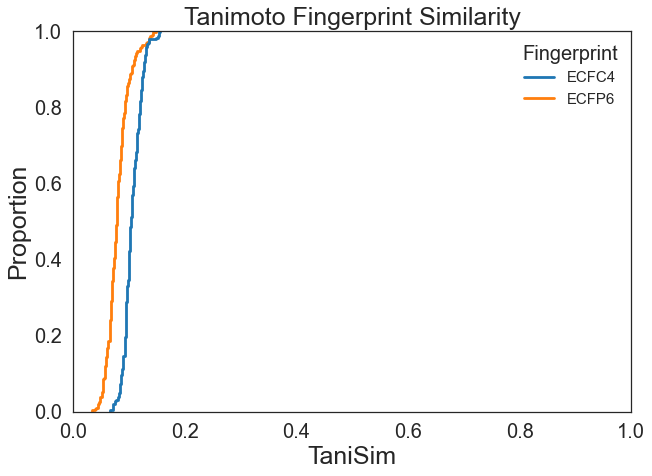

In [12]:
tmp = pd.melt(df_tani, id_vars=['Cpd_Id'], value_vars=["ECFC4", "ECFP6"],
              var_name="Fingerprint", value_name="TaniSim")
plt.figure(figsize=(10, 7))
sns.ecdfplot(data=tmp, x="TaniSim", stat="proportion", hue="Fingerprint")
plt.xlim((0, 1));
# plt.legend();
plt.title(f"Tanimoto Fingerprint Similarity")
plt.savefig("output/ecdf_tani_sim_murcko.png");
plt.savefig("output/ecdf_tani_sim_murcko.svg");